<a href="https://colab.research.google.com/github/AbhinavDwivediii/Deep-Learning-Lab/blob/main/DL_Exp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== CATS VS DOGS CLASSIFICATION WITH TRANSFER LEARNING ===

1. LOADING DATASET...
Loading cats images...
Found 500 cat images
Loading dogs images...
Found 500 dog images

Total images loaded: 1000
Cats: 500, Dogs: 500
Training set: 800 images
Test set: 200 images

2. EXPLORATORY DATA ANALYSIS...


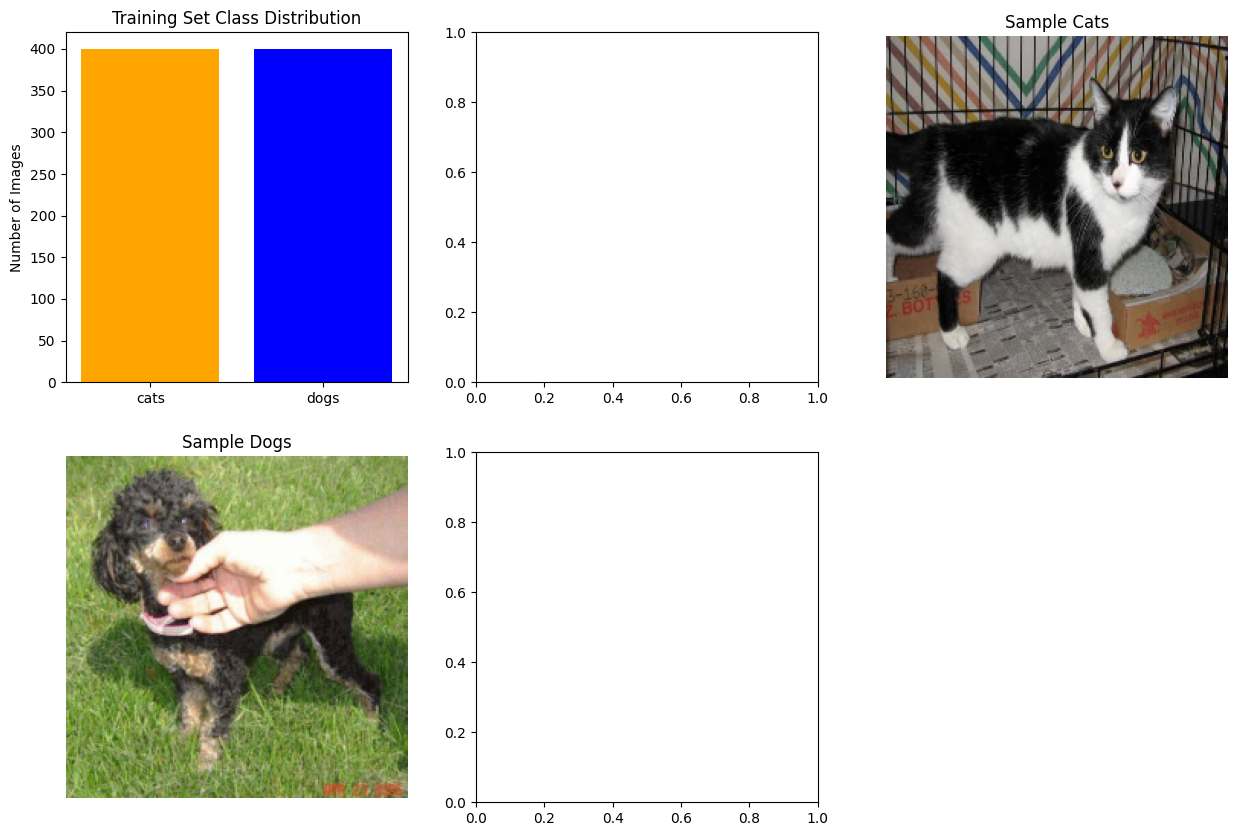

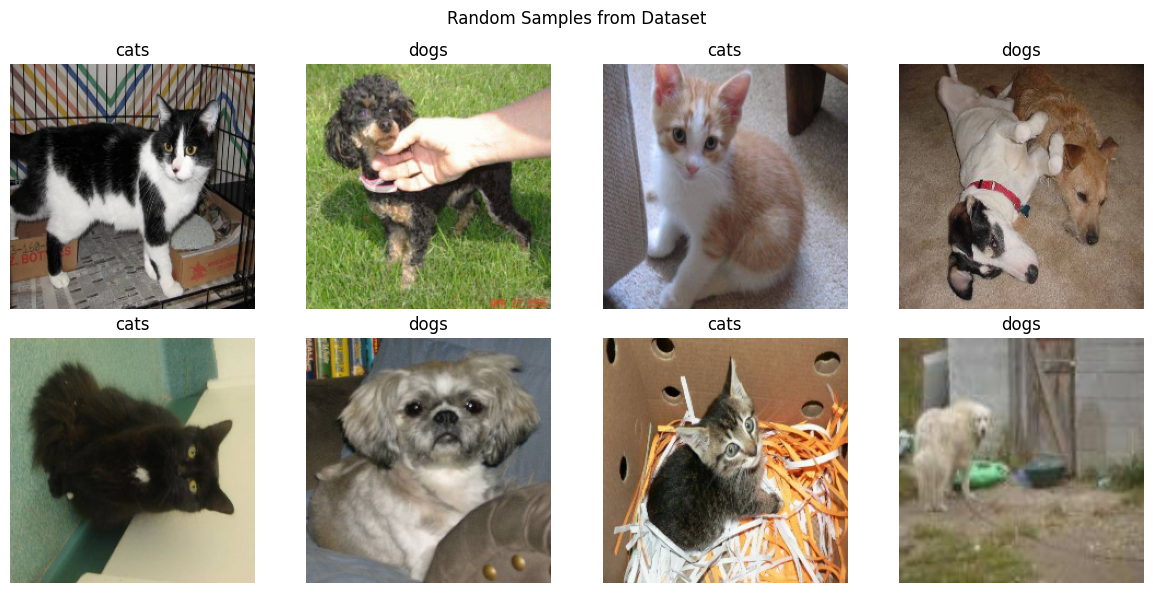

Final training set: (640, 224, 224, 3)
Validation set: (160, 224, 224, 3)

3. BUILDING TRANSFER LEARNING MODEL...
Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


4. TRAINING MODEL...
Phase 1: Feature Extraction (10 epochs)
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 160s 8s/step - accuracy: 0.4929 - loss: 0.9616 - val_accuracy: 0.5000 - val_loss: 0.8342
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.4970 - loss: 0.8984 - val_accuracy: 0.5312 - val_loss: 0.6804
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - accuracy: 0.5359 - loss: 0.7792 - val_accuracy: 0.6625 - val_loss: 0.6573
Epoch 4/10


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import os
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
import zipfile

np.random.seed(42)
tf.random.set_seed(42)

# Dataset paths
cats_zip_path = 'cats_set-20251102T192741Z-1-001.zip'
dogs_zip_path = 'dogs_set-20251102T192743Z-1-001.zip'
dataset_dir = 'EXP_4_DATASET'
cats_dir = os.path.join(dataset_dir, 'cats_set')
dogs_dir = os.path.join(dataset_dir, 'dogs_set')
class_names = ['cats', 'dogs']

print("=== CATS VS DOGS CLASSIFICATION WITH TRANSFER LEARNING ===\n")

# Unzip datasets if not already extracted
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    print(f"Extracting {cats_zip_path}...")
    with zipfile.ZipFile(cats_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

    print(f"Extracting {dogs_zip_path}...")
    with zipfile.ZipFile(dogs_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)


# 1. DATASET LOADING
print("1. LOADING DATASET...")

def load_cats_dogs_dataset():
    images = []
    labels = []

    print("Loading cats images...")
    if os.path.exists(cats_dir):
        cat_files = [f for f in os.listdir(cats_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Found {len(cat_files)} cat images")

        for filename in cat_files:
            img_path = os.path.join(cats_dir, filename)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(0)
            except:
                continue

    print("Loading dogs images...")
    if os.path.exists(dogs_dir):
        dog_files = [f for f in os.listdir(dogs_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Found {len(dog_files)} dog images")

        for filename in dog_files:
            img_path = os.path.join(dogs_dir, filename)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(1)
            except:
                continue

    return np.array(images), np.array(labels)

X_all, y_all = load_cats_dogs_dataset()
print(f"\nTotal images loaded: {len(X_all)}")
print(f"Cats: {np.sum(y_all == 0)}, Dogs: {np.sum(y_all == 1)}")

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# 2. EXPLORATORY DATA ANALYSIS AND PREPROCESSING
print("\n2. EXPLORATORY DATA ANALYSIS...")

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
unique, counts = np.unique(y_train, return_counts=True)
plt.bar([class_names[i] for i in unique], counts, color=['orange', 'blue'])
plt.title('Training Set Class Distribution')
plt.ylabel('Number of Images')

plt.subplot(2, 3, 2)
sample_indices = [np.where(y_train == 0)[0][0], np.where(y_train == 1)[0][0]]
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 3, 3 + i)
    plt.imshow(X_train[idx])
    plt.title(f'Sample {class_names[i].capitalize()}')
    plt.axis('off')

plt.subplot(2, 3, 5)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    class_idx = i % 2
    sample_idx = np.where(y_train == class_idx)[0][i//2]
    axes[i//4, i%4].imshow(X_train[sample_idx])
    axes[i//4, i%4].set_title(class_names[class_idx])
    axes[i//4, i%4].axis('off')
plt.suptitle('Random Samples from Dataset')
plt.tight_layout()

plt.show()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train_categorical = to_categorical(y_train, 2)
y_test_categorical = to_categorical(y_test, 2)

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_categorical, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Final training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")

# 3. BUILDING TRANSFER LEARNING MODEL
print("\n3. BUILDING TRANSFER LEARNING MODEL...")

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

# 4. TRAINING THE MODEL
print("\n4. TRAINING MODEL...")

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

print("Phase 1: Feature Extraction (10 epochs)")
history1 = model.fit(
    datagen.flow(X_train_split, y_train_split, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1
)

print("\nPhase 2: Fine-tuning")
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Fine-tuning (10 more epochs)")
history2 = model.fit(
    datagen.flow(X_train_split, y_train_split, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1
)

history_combined = {
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss']
}

# 5. MODEL EVALUATION
print("\n5. MODEL EVALUATION...")

y_pred_val = model.predict(X_val)
y_pred_classes_val = np.argmax(y_pred_val, axis=1)
y_true_val = np.argmax(y_val, axis=1)

y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

accuracy_val = accuracy_score(y_true_val, y_pred_classes_val)
precision_val = precision_score(y_true_val, y_pred_classes_val, average='weighted')
recall_val = recall_score(y_true_val, y_pred_classes_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_classes_val, average='weighted')

accuracy_test = accuracy_score(y_test, y_pred_classes_test)
precision_test = precision_score(y_test, y_pred_classes_test, average='weighted')
recall_test = recall_score(y_test, y_pred_classes_test, average='weighted')
f1_test = f1_score(y_test, y_pred_classes_test, average='weighted')

print("VALIDATION METRICS:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1-Score: {f1_val:.4f}")

print("\nTEST METRICS:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

cm_val = confusion_matrix(y_true_val, y_pred_classes_val)
tn, fp, fn, tp = cm_val.ravel()
specificity_val = tn / (tn + fp)
print(f"Specificity (Validation): {specificity_val:.4f}")

# 6. VISUALIZATIONS
print("\n6. VISUALIZATIONS...")

plt.figure(figsize=(20, 12))

plt.subplot(2, 4, 1)
plt.plot(history_combined['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(history_combined['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axvline(x=9, color='g', linestyle='--', alpha=0.7, label='Fine-tuning starts')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 2)
plt.plot(history_combined['loss'], 'bo-', label='Training Loss')
plt.plot(history_combined['val_loss'], 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.axvline(x=9, color='g', linestyle='--', alpha=0.7, label='Fine-tuning starts')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 3)
cm_normalized = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 4, 4)
y_true_bin = label_binarize(y_true_val, classes=[0, 1])
y_pred_bin = y_pred_val

# ✅ Fixed ROC plotting
for i, class_name in enumerate(class_names):
    if y_true_bin.shape[1] > i:  # Only plot if class exists
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label=f'{class_name.capitalize()} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 5)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
val_scores = [accuracy_val, precision_val, recall_val, f1_val]
test_scores = [accuracy_test, precision_test, recall_test, f1_test]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, val_scores, width, label='Validation', color='lightblue')
plt.bar(x + width/2, test_scores, width, label='Test', color='lightcoral')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)
for i, (v, t) in enumerate(zip(val_scores, test_scores)):
    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, t + 0.01, f'{t:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# AUC Scores
if y_true_bin.shape[1] == 2:
    micro_auc = roc_auc_score(y_true_bin, y_pred_bin, average='micro')
    macro_auc = roc_auc_score(y_true_bin, y_pred_bin, average='macro')
    print(f"\nMicro-average ROC AUC: {micro_auc:.4f}")
    print(f"Macro-average ROC AUC: {macro_auc:.4f}")

# 7. DETAILED CLASSIFICATION REPORT
print("\n7. DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_true_val, y_pred_classes_val, target_names=class_names))

print("\nTEST SET CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_classes_test, target_names=class_names))